In [2]:
import tensorflow as tf
from model import Model
from input_pipe import InputPipe
from feeder import VarFeeder
from tqdm import trange
import matplotlib.pyplot as plt
import collections
import pandas as pd
import numpy as np
from trainer import predict
from hparams import build_hparams
import hparams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
print(tf.__version__)
def smape(true, pred):
    summ = np.abs(true) + np.abs(pred)
    smape = np.where(summ == 0, 0, np.abs(true - pred) / summ)
    #return np.mean(kaggle_smape) * 200
    return smape * 200

def mean_smape(true, pred):
    raw_smape = smape(true, pred)
    masked_smape = np.ma.array(raw_smape, mask=np.isnan(raw_smape))
    return masked_smape.mean()

1.4.1


In [5]:
from make_features import read_all
df_all = read_all()
df_all.columns

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2017-09-02', '2017-09-03', '2017-09-04', '2017-09-05',
               '2017-09-06', '2017-09-07', '2017-09-08', '2017-09-09',
               '2017-09-10', '2017-09-11'],
              dtype='datetime64[ns]', length=804, freq=None)

In [6]:
prev = df_all#.loc[:,:'2017-07-08']


In [7]:
paths = [p for p in tf.train.get_checkpoint_state('data/cpt/s32').all_model_checkpoint_paths]

In [8]:
#tf.reset_default_graph()
#preds = predict(paths, default_hparams(), back_offset=0,
#                    n_models=3, target_model=0, seed=2, batch_size=2048, asgd=True)
t_preds = []
for tm in range(3):
    tf.reset_default_graph()
    t_preds.append(predict(paths, build_hparams(hparams.params_s32), back_offset=0, predict_window=63,
                    n_models=3, target_model=tm, seed=2, batch_size=2048, asgd=True))


INFO:tensorflow:Restoring parameters from data/vars/feeder.cpt
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-10944
0......................................................................🎉
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-11001
0......................................................................🎉
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-11058
0......................................................................🎉
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-11115
0......................................................................🎉
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-11172
0......................................................................🎉
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-11229
0......................................................................🎉
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-11286
0...........................................

In [9]:
preds=sum(t_preds) /3

In [10]:
missing_pages = prev.index.difference(preds.index)
# Use zeros for missing pages
rmdf = pd.DataFrame(index=missing_pages,
                    data=np.tile(0, (len(preds.columns),len(missing_pages))).T, columns=preds.columns)
f_preds = preds.append(rmdf).sort_index()

# Use zero for negative predictions
f_preds[f_preds < 0.5] = 0
# Rouns predictions to nearest int
f_preds = np.round(f_preds).astype(np.int64)

Visual sanity check

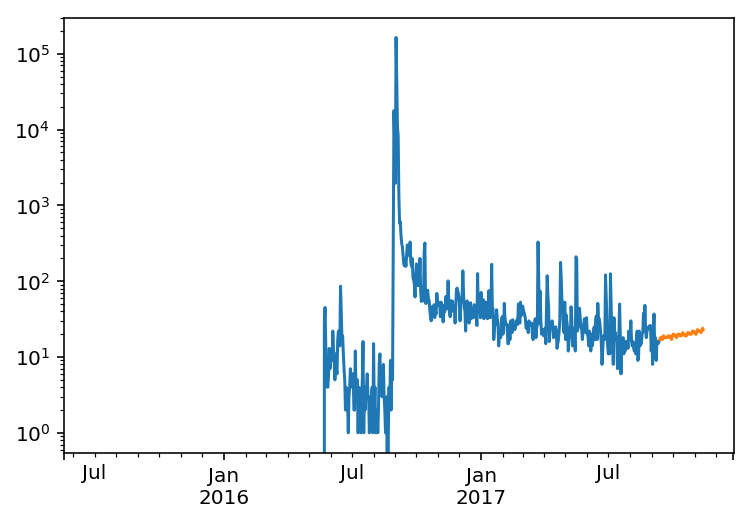

In [11]:
page = '(236984)_Astier_fr.wikipedia.org_all-access_all-agents'
#page = '龍抬頭_zh.wikipedia.org_mobile-web_all-agents'
#page = "'Tis_the_Season_(Vince_Gill_and_Olivia_Newton-John_album)_en.wikipedia.org_mobile-web_all-agents"
#page='Peter_Townsend_(RAF_officer)_en.wikipedia.org_mobile-web_all-agents'
#page="Heahmund_en.wikipedia.org_desktop_all-agents"
prev.loc[page].fillna(0).plot(logy=True)

#gt.loc[page].fillna(0).plot(logy=True)
f_preds.loc[page].plot(logy=True)

In [12]:
def read_keys():
    import os.path
    key_file = 'data/keys2.pkl'
    if os.path.exists(key_file):
        return pd.read_pickle(key_file)
    else:
        print('Reading keys...')
        raw_keys = pd.read_csv('data/key_2.csv.zip')
        print('Processing keys...')
        pagedate = raw_keys.Page.str.rsplit('_', expand=True, n=1).rename(columns={0:'page',1:'date_str'})
        keys = raw_keys.drop('Page', axis=1).assign(page=pagedate.page, date=pd.to_datetime(pagedate.date_str))
        del raw_keys, pagedate
        print('Pivoting keys...')
        pkeys = keys.pivot(index='page', columns='date', values='Id')
        print('Storing keys...')
        pkeys.to_pickle(key_file)
        return pkeys
keys = read_keys()    

Reading keys...
Processing keys...
Pivoting keys...
Storing keys...


In [13]:
subm_preds = f_preds.loc[:, '2017-09-13':]
assert np.all(subm_preds.index == keys.index)
assert np.all(subm_preds.columns == keys.columns)
answers = pd.DataFrame({'Id':keys.values.flatten(), 'Visits':np.round(subm_preds).astype(np.int64).values.flatten()})
answers.to_csv('data/submission.csv.gz', compression='gzip', index=False, header=True)


In [14]:
f_preds

,2017-09-12 00:00:00,2017-09-13 00:00:00,2017-09-14 00:00:00,2017-09-15 00:00:00,2017-09-16 00:00:00,2017-09-17 00:00:00,2017-09-18 00:00:00,2017-09-19 00:00:00,2017-09-20 00:00:00,2017-09-21 00:00:00,...,2017-11-04 00:00:00,2017-11-05 00:00:00,2017-11-06 00:00:00,2017-11-07 00:00:00,2017-11-08 00:00:00,2017-11-09 00:00:00,2017-11-10 00:00:00,2017-11-11 00:00:00,2017-11-12 00:00:00,2017-11-13 00:00:00
!vote_en.wikipedia.org_all-access_all-agents,11,10,10,9,9,9,9,10,9,9,...,7,6,7,7,7,7,7,7,7,7
!vote_en.wikipedia.org_all-access_spider,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
!vote_en.wikipedia.org_desktop_all-agents,5,5,5,4,4,4,5,5,5,5,...,4,3,4,4,4,4,4,4,3,4
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents",1096,1109,1104,1076,1066,1097,1128,1125,1117,1106,...,1141,1163,1180,1182,1175,1168,1155,1158,1174,1191
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider",22,22,21,20,20,20,20,20,20,20,...,19,18,18,18,18,18,18,19,18,18
"""Awaken,_My_Love!""_en.wikipedia.org_desktop_all-agents",660,665,655,623,573,593,651,656,653,645,...,605,619,657,661,660,655,642,615,622,661
"""European_Society_for_Clinical_Investigation""_en.wikipedia.org_all-access_all-agents",1,1,1,1,2,1,2,2,1,1,...,2,1,1,1,1,1,1,2,1,1
"""European_Society_for_Clinical_Investigation""_en.wikipedia.org_all-access_spider",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""European_Society_for_Clinical_Investigation""_en.wikipedia.org_desktop_all-agents",1,1,1,2,2,1,2,2,2,2,...,2,1,1,1,1,1,1,2,1,1
"""Heroes""_(David_Bowie_album)_en.wikipedia.org_all-access_all-agents",615,618,616,606,602,615,630,623,628,619,...,627,635,636,631,631,608,605,607,629,632


In [15]:
prev.loc[missing_pages, '2016-12-15':]

,2016-12-15 00:00:00,2016-12-16 00:00:00,2016-12-17 00:00:00,2016-12-18 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-24 00:00:00,...,2017-09-02 00:00:00,2017-09-03 00:00:00,2017-09-04 00:00:00,2017-09-05 00:00:00,2017-09-06 00:00:00,2017-09-07 00:00:00,2017-09-08 00:00:00,2017-09-09 00:00:00,2017-09-10 00:00:00,2017-09-11 00:00:00
100_лучших_героев_комиксов_по_версии_IGN_ru.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN
100_лучших_героев_комиксов_по_версии_IGN_ru.wikipedia.org_desktop_all-agents,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN
100_лучших_героев_комиксов_по_версии_IGN_ru.wikipedia.org_mobile-web_all-agents,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015年華潔洗滌罷工事件_zh.wikipedia.org_all-access_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015年華潔洗滌罷工事件_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015年華潔洗滌罷工事件_zh.wikipedia.org_desktop_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
????:Andrey_Belloly_1.jpg_ru.wikipedia.org_all-access_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
????:Andrey_Belloly_1.jpg_ru.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
????:Andrey_Belloly_1.jpg_ru.wikipedia.org_desktop_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Akash_Thosar_en.wikipedia.org_mobile-web_all-agents,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
